# Text Summarizer

The aim of this project is to build a text summarizer that summarize Amazon Reviews. There is an enourmous amount of text in the world today. 

Automatic summarization is the process of shortening a text document with software, in order to create a summary with the major points of the original document. 

This model could be addapted to fields such as Medical summarization, 

In [66]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import fastText as ft
import os
import pickle
import random
import sys

# torch imports 
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.autograd import Variable

# my file imports 
from utils import save_array, load_array, get_vecs
from preprocessing import Tokenizer, TextDataSet, limit_unk_vocab
from dataset import TextDataLoader
from model import Seq2SeqAttention
from train import fit

import warnings
warnings.filterwarnings('ignore')

Lets read the data in. You can easily get this data from [Kaggle's Amazon Fine Food Reviews'](https://www.kaggle.com/snap/amazon-fine-food-reviews/data). And store the `Reviews.csv` file in the `data/` directory. 

In [4]:
DATA_PATH = 'data/'
reviews = pd.read_csv(f'{DATA_PATH}Reviews.csv', usecols=['Summary', 'Text'])
# drop rows with no Summary
reviews.dropna(inplace=True)
# drop duplicated 
reviews.drop_duplicates(['Text'], keep='first', inplace=True)
print('total reviews', reviews.shape[0])
reviews.head(5)

total reviews 393576


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


Lets plot some basic text and summary length plots. This will also give us some intuition based on our 'padding' we perform later

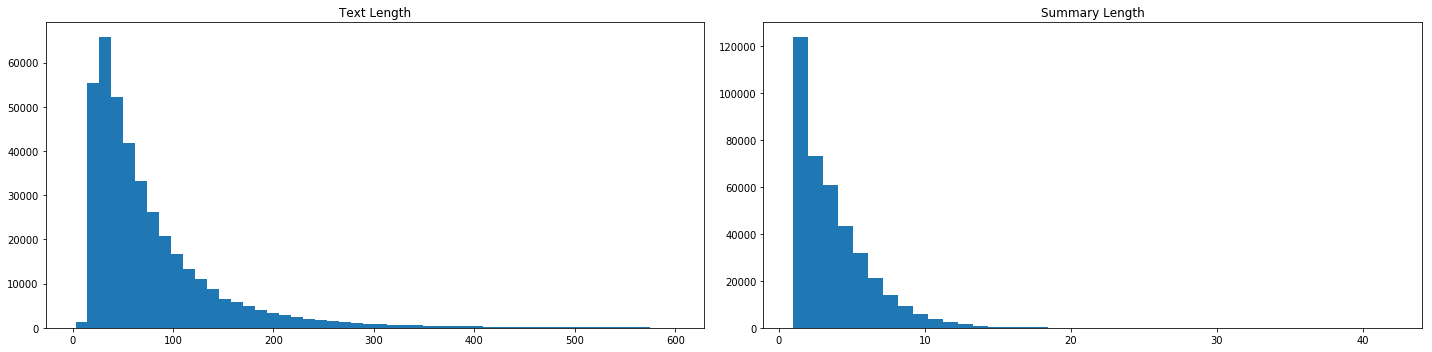

In [6]:
reviews['Summary_len'] = reviews.Summary.apply(lambda x: len(x.split()))
reviews['Text_len'] = reviews.Text.apply(lambda x: len(x.split()))  

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(reviews.Text_len[reviews['Text_len'] < 600], bins=50)
plt.title('Text Length')

plt.subplot(1, 2, 2)
plt.hist(reviews['Summary_len'], bins=40)
plt.title('Summary Length')
plt.tight_layout()

Typical log normal distribution. You can see that there are some very short reviews in this dataset. Checking a few out manually, many have no relevance for our task, so they can simply be dropped. 

In [7]:
# drop short reviews < 10
reviews = reviews[reviews['Text_len'] > 10]
print('total reviews', reviews.shape[0])

total reviews 393470


Lets split the data into training and testing so we can have a fair estimate in how our model would perform on out-of-sample data. This is definitely a required step in this particular project, since we are planning on using teacher forcing (explained later) in the training phase. 

In [8]:
train_df, test_df = train_test_split(reviews, test_size=0.1, random_state=100)

## Pre-Processing Text
To create the lengths of `idx2word` and `word2idx` we can check out the percentile values from the training set for the Text and Summary lengths. We use 90% for text and 99% for the summary. We can chop off a bit more text to reduce the padded tokens, but we keep most of the summary length and just pad. As you can see later we choose 150 for the text length and 12 for the summary length.

In [9]:
print('Text length 90 percentile:', np.percentile(train_df.Text_len, 90))
print('Summary length 99 percentile:', np.percentile(train_df.Summary_len, 99))

Text length 90 percentile: 159.79999999998836
Summary length 99 percentile: 12.0


To create our `idx2word` and `word2idx` we concatenate our reviews and summaries into one long corpus. It make sense that our `idx2word` and `word2idx` should contain all the tokens we have in our dataset. 

This `TextDataSet` class does does all the pre-processing for us. First it tokenizes the data with [spacy](https://spacy.io/)  

Another thing to note here is that the `Tokenizer()` class uses multiprocessing and paralizes multiple cores on your machince. This is definitely necessary when trying to process this many reviews at once. 

I found this out the hard way. Before using multiprocessing and "chunking", this code cell below took 9 hours to run, now it takes around one minute to complete. You can check out the code [here](LINK) in how this was done.

If you want to learn a bit more in how to use the [multiprocessing](https://docs.python.org/2/library/multiprocessing.html) library, you might find this [basic tutorial helpful](https://www.youtube.com/watch?v=oEYDqQ1pq9o)

In [10]:
%%time
max_vocab_text = 10000
maxlen_text = 150
maxlen_summary = 12

# all text model
all_text_raw = np.concatenate([train_df.Text.values, train_df.Summary.values])

all_text_model = TextDataSet(max_vocab=max_vocab_text, maxlen=maxlen_text, min_freq=2, padding='post')
all_text = all_text_model.fit(all_text_raw, tokenize=True)

CPU times: user 7.24 s, sys: 782 ms, total: 8.02 s
Wall time: 1min 4s


Now we can `transform` our `Text` and `Summary` fields to create our padded text and summary. One thing to note here is that we add a beginning of sentence tag (`_bos_`) and end of sentence tag (`_eos_`) to the `Summary` field. This is necessary so the model can learn when to stop which helps computation time. 

In [11]:
%%time
# Text Field
train_text = all_text_model.transform(train_df.Text.values, word2idx=all_text_model.word2idx, padding='pre')
test_text = all_text_model.transform(test_df.Text.values, word2idx=all_text_model.word2idx, padding='pre')

# Summary
train_df['Summary'] = '_bos_' + ' ' + train_df['Summary'] + ' ' + '_eos_'
test_df['Summary'] = '_bos_' + ' ' + test_df['Summary'] + ' ' + '_eos_'

train_summary = all_text_model.transform(train_df.Summary.values, word2idx=all_text_model.word2idx, maxlen=maxlen_summary, padding='post')
test_summary = all_text_model.transform(test_df.Summary.values, word2idx=all_text_model.word2idx, maxlen=maxlen_summary, padding='post')

CPU times: user 15.3 s, sys: 1.98 s, total: 17.3 s
Wall time: 56.8 s


Another thing we do here to limit the amount of data here is to limit the data to only have 2 UNK occurnces in text and 1 UNK occurance in summary.  This is done to ensure that we are building the model with meaningful data.

In [12]:
%%time
max_unk_text = 2
max_unk_summary = 1

train_text, train_summary = limit_unk_vocab(train_text, train_summary, all_text_model, max_unk_text, max_unk_summary)

new text size 284229
new summary size 284229
CPU times: user 57.4 s, sys: 188 ms, total: 57.6 s
Wall time: 57.6 s


A simple cell to save / load the data and model. Upate the `SAVE` and `LOAD` flags appropiately. 

In [13]:
SAVE = False
LOAD = True

if SAVE:
    save_array(all_text, 'all_text.npy')
    save_array(train_text, 'train_text.npy')
    save_array(test_text, 'test_text.npy')
    save_array(train_summary, 'train_summary.npy')
    save_array(test_summary, 'test_summary.npy')
    
if LOAD:  
    # TODO pickle model
    all_text_model = TextDataSet(max_vocab=max_vocab_text, maxlen=maxlen_text, min_freq=2, padding='post')
    all_text = all_text_model.fit(all_text_raw, tokenize=True)
    all_text = load_array('all_text.npy')
    train_text = load_array('train_text.npy')
    test_text = load_array('test_text.npy')
    train_summary = load_array('train_summary.npy')
    test_summary = load_array('test_summary.npy')

## Embeddings 

For our word vectors for our model, have decided to go with the Pre-trained [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md). Make sure you download the english  "bin+text" and save the `wiki.en.bin` file in your `data/` path.  

Direct link for the download is [here](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip). 


Then you can run this code below to pickle and return the word vectors. If you have already pickled the files, you can just read them from disk. 

In [14]:
download_vectors = False

if download_vectors:
    # warning this is not tested, since I removed my file, but should work  
    word_vector_path = os.path.join(DATA_PATH, 'wiki.en.bin')
    en_vecs = ft.load_model(word_vector_path)
    en_vecd = get_vecs(en_vecs)
else:
    en_vecd = pickle.load(open(os.path.join(DATA_PATH, 'wiki.en.pkl'),'rb'))
    dim_en_vec = len(en_vecd[','])

print('word embedding shape', dim_en_vec)

word embedding shape 300


# Get Data

Let's create our pytorch `Dataset` and load in the data. This makes our life much easier since it bathces the data for us!

If you are not using a GPU would suggest using using a `subset` of the data, since this model takes a long time to train and you can still get some good results with `10000` datapoints.

In [46]:
reduced_set = True

subset = None
if reduced_set:
    subset = 10000

train_loader = DataLoader(TextDataLoader(train_text[:subset], train_summary[:subset], transpose=False), batch_size=32)
test_loader = DataLoader(TextDataLoader(test_text[:subset], test_summary[:subset], transpose=False), batch_size=32) 

print('training set size:', len(train_loader.dataset))
print('testing set size:', len(test_loader.dataset))

training set size: 10000
testing set size: 10000


# Model

Now lets initialize our model. There is really only one valid choice any more in NLP tasks. Can you guess what it is? Yup, you guesed it! Bi-directional RNN with attention! 

Therefore we have decided to use a GRU, initialize with the FastText word embeddings, 256 hidden nodes for the RNN, 2 layers for the RNN, and use tanh for the activation in the attention mechanism.

You can check out the full model implemention in the [model.py](LINK) file. 

In [67]:
num_hidden = 256
num_layers = 2
activation = F.tanh

model = Seq2SeqAttention(vecs_enc=en_vecd, idx2word_enc=all_text_model.idx2word, em_sz_enc=dim_en_vec, 
                         vecs_dec=en_vecd, idx2word_dec=all_text_model.idx2word, em_sz_dec=dim_en_vec, 
                         num_hidden=num_hidden, out_seq_length=maxlen_summary, num_layers=num_layers, 
                         activation=activation, pad_idx=all_text_model.word2idx['_pad_']).cuda()

In [68]:
model

Seq2SeqAttention(
  (encoder_embeddings): Embedding(10004, 300, padding_idx=1)
  (encoder_dropout_emb): Dropout(p=0.1)
  (encoder_dropout): Dropout(p=0.1)
  (encoder_gru): GRU(300, 256, num_layers=2, bidirectional=True)
  (encoder_out): Linear(in_features=512, out_features=300, bias=False)
  (decoder_embeddings): Embedding(10004, 300, padding_idx=1)
  (decoder_dropout): Dropout(p=0.1)
  (decoder_gru): GRU(300, 300, num_layers=2)
  (out): Linear(in_features=256, out_features=10004, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=812, out_features=300, bias=True)
)

# Fit Model 

In [69]:
%%time
# tr_ratios = np.concatenate([np.ones(10), np.linspace(1.0, 0, 10)])
tr_ratios = np.ones(10)
history = fit(model, train_loader, val_loader=test_loader, learning_rate=1e-4, epochs=len(tr_ratios), 
            grad_clip=5.0, pad=all_text_model.word2idx['_pad_'], tr_ratios=tr_ratios, 
            print_period=100, save=True, return_history=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))


epoch_loss: 3.47867, % of epoch: (96%)
 [1, 4.304499858220418, 8.049896876017252]
epoch_loss: 2.64058, % of epoch: (96%)
 [2, 2.8103661568959555, 7.645735294390947]
epoch_loss: 2.48414, % of epoch: (96%)
 [3, 2.505710711876551, 7.77374209348972]
epoch_loss: 2.37931, % of epoch: (96%)
 [4, 2.3777267396450044, 8.171548455189436]
epoch_loss: 2.31677, % of epoch: (96%)
 [5, 2.291014556090037, 8.24207215431409]
epoch_loss: 2.26424, % of epoch: (96%)
 [6, 2.224771398703257, 8.239342999763977]
epoch_loss: 2.22566, % of epoch: (96%)
 [7, 2.1734158118565876, 8.16365389029185]
epoch_loss: 2.19282, % of epoch: (96%)
 [8, 2.1255870505174, 7.95916625780937]
epoch_loss: 2.16657, % of epoch: (96%)
 [9, 2.085987996260325, 7.749525209267934]
epoch_loss: 2.14748, % of epoch: (96%)
 [10, 2.0499288702011107, 7.736169741703914]

CPU times: user 3min 8s, sys: 31.7 s, total: 3min 40s
Wall time: 3min 40s


In [70]:
%%time
# tr_ratios = np.concatenate([np.ones(20), np.linspace(1.0, 0, 20)])
tr_ratios = np.ones(10)
epochs = len(tr_ratios)

history2 = fit(model, train_loader, val_loader=test_loader, learning_rate=1e-4, epochs=epochs, grad_clip=5.0, 
            pad=all_text_model.word2idx['_pad_'], tr_ratios=tr_ratios, 
            print_period=100, save=True, return_history=True, pre_saved=True)

...restoring model...


HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch_loss: 2.48426, % of epoch: (96%)
 [1, 2.50359778602918, 7.954880876418872]
epoch_loss: 2.37177, % of epoch: (96%)
 [2, 2.373790627717972, 8.26057740358206]
epoch_loss: 2.31398, % of epoch: (96%)
 [3, 2.289622770547867, 8.236850009514736]
epoch_loss: 2.26171, % of epoch: (96%)
 [4, 2.22232888062795, 8.155552945075891]
epoch_loss: 2.22084, % of epoch: (96%)
 [5, 2.168982258637746, 8.203714173573713]
epoch_loss: 2.19167, % of epoch: (96%)
 [6, 2.123908087412516, 7.791981455607292]
epoch_loss: 2.16255, % of epoch: (96%)
 [7, 2.0807828561464947, 7.613672941158979]
epoch_loss: 2.13985, % of epoch: (96%)
 [8, 2.0465347599983215, 7.70431249263959]
epoch_loss: 2.12308, % of epoch: (96%)
 [9, 2.013293623526891, 7.67002134063305]
epoch_loss: 2.10660, % of epoch: (96%)
 [10, 1.9853131477038068, 7.555220325787862]

CPU times: user 3min 9s, sys: 32.8 s, total: 3min 42s
Wall time: 3min 42s


In [71]:
tr_ratios = np.ones(10)
epochs = len(tr_ratios)

history3 = fit(model, train_loader, val_loader=test_loader, learning_rate=1e-4, epochs=epochs, grad_clip=5.0, 
            pad=all_text_model.word2idx['_pad_'], tr_ratios=tr_ratios, 
            print_period=100, save=True, return_history=True, pre_saved=True)

...restoring model...


HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch_loss: 2.09860, % of epoch: (96%)
 [1, 1.9581928968429565, 7.521716819359706]
epoch_loss: 2.08919, % of epoch: (96%)
 [2, 1.9319393881162006, 7.435058807715391]
epoch_loss: 2.07559, % of epoch: (96%)
 [3, 1.905937081972758, 7.402395262932166]
epoch_loss: 2.06703, % of epoch: (96%)
 [4, 1.8818235858281451, 7.332715553350938]
epoch_loss: 2.06385, % of epoch: (96%)
 [5, 1.86053608695666, 7.385508596897125]
epoch_loss: 2.05720, % of epoch: (96%)
 [6, 1.8402832372983298, 7.266566527195466]
epoch_loss: 2.05406, % of epoch: (96%)
 [7, 1.8190951585769655, 7.280574868122737]
epoch_loss: 2.04855, % of epoch: (96%)
 [8, 1.7963927888870241, 7.271519362926483]
epoch_loss: 2.04973, % of epoch: (96%)
 [9, 1.7787497985363008, 7.318887846592145]
epoch_loss: 2.05221, % of epoch: (96%)
 [10, 1.7624048157533008, 7.165232765368926]



In [72]:
tr_ratios = np.concatenate([np.ones(20), np.linspace(1.0, 0, 20)])
epochs = len(tr_ratios)

history4 = fit(model, train_loader, val_loader=test_loader, learning_rate=1e-4, epochs=epochs, grad_clip=5.0, 
            pad=all_text_model.word2idx['_pad_'], tr_ratios=tr_ratios, 
            print_period=100, save=True, return_history=True, pre_saved=True)

...restoring model...


HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch_loss: 2.05124, % of epoch: (96%)
 [1, 1.7448137374718984, 7.195053111284207]
epoch_loss: 2.04781, % of epoch: (96%)
 [2, 1.7266967463493348, 7.145286066409869]
epoch_loss: 2.04769, % of epoch: (96%)
 [3, 1.7080786726872128, 7.281891159522227]
epoch_loss: 2.04747, % of epoch: (96%)
 [4, 1.689365822871526, 7.277518041622945]
epoch_loss: 2.05057, % of epoch: (96%)
 [5, 1.6733684728542961, 7.24009998792257]
epoch_loss: 2.04837, % of epoch: (96%)
 [6, 1.6563760552803677, 7.375762129441286]
epoch_loss: 2.05457, % of epoch: (96%)
 [7, 1.6410426147778832, 7.456949697091029]
epoch_loss: 2.06122, % of epoch: (96%)
 [8, 1.6266506340106328, 7.494417636822432]
epoch_loss: 2.06951, % of epoch: (96%)
 [9, 1.6110165919860204, 7.381957749525706]
epoch_loss: 2.06451, % of epoch: (96%)
 [10, 1.5931196665763856, 7.522964572295164]
epoch_loss: 2.07666, % of epoch: (96%)
 [11, 1.5796181406577425, 7.559664926467797]
epoch_loss: 2.08373, % of epoch: (96%)
 [12, 1.567175150712331, 7.6416649130674505]
epo

In [77]:
# model = torch.load('models/checkpoint.pth.tar')

# Training / Testing Loss

We can plot the training and validation loss. We can also overlay the teacher forcing ratios. 

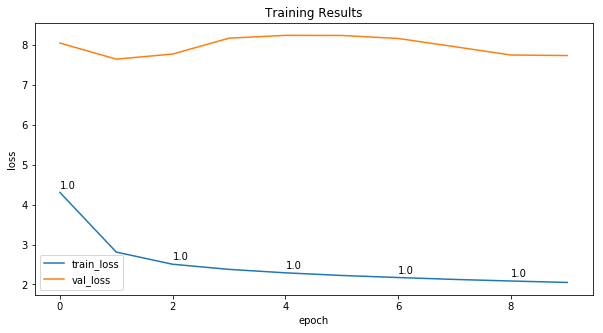

In [73]:
def plot_loss(every=1):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    for i, (loss, tr_ratio) in enumerate(zip(history['train_loss'], tr_ratios)):
        if i % every == 0:
            plt.annotate(str(np.round(tr_ratio, 2)), xy=(float(i), loss+0.1))
    plt.legend()
    plt.title('Training Results')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
plot_loss(2)

We can also check out the cyclical learning rates.

Text(0,0.5,'iterations')

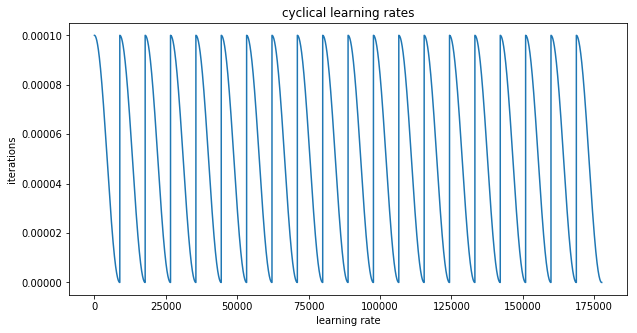

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(history['all_lr']);
plt.title('cyclical learning rates')
plt.xlabel('learning rate')
plt.ylabel('iterations')

# Extrinsic Evaluation

Now we can see how the model actually performs. Another cool thing we can do with an attention model, is check out the softmax weights for each of the input words in the text.  

In [78]:
import torch
from torch.autograd import Variable

def get_max(probs, top=2, unk=0):
    preds = []
    for top_preds in probs.topk(top)[1].data.cpu().numpy():
        top_preds = top_preds.flatten()
        final_pred = top_preds[0]
        if top > 1: 
            if top_preds[0] == unk:
                print(top_preds[0])
                final_pred = top_preds[1]
        preds.append(final_pred)
    return preds

def get_idx2word(data, idx, idx2word, pad=1):
    return [idx2word[i] for i in data[idx] if i != pad]

def generate_example(text=None, summary=None, idx=None, plot_attention=False, pad=1, unk=0):
    if idx is None:
        idx = np.random.randint(0, len(train_text_reduced), size=1)[0]
    x = np.expand_dims(text[idx], 1)
    y = np.expand_dims(summary[idx], 1)
    x_v = Variable(torch.from_numpy(x).long()).cuda()
    y_v = Variable(torch.from_numpy(y).long()).cuda()

    probs, attentions = model(x_v, y_v, return_attention=True)
    original_text = get_idx2word(text, idx, all_text_model.idx2word, pad=pad)
    original_text_len = len(original_text)
    original_summary = get_idx2word(summary, idx, all_text_model.idx2word, pad=pad)
    preds = [all_text_model.idx2word[i] for i in get_max(probs, unk=unk) if i != pad]
    print('ORIGINAL TEXT:')
    print(' '.join(original_text))
    print('ORIGINAL SUMMARY:')
    print(' '.join(original_summary))
    print('MODEL PREDICTION:')
    print(' '.join(preds))
    if plot_attention:
        plt.figure(figsize=(15, 5))
        x = attentions.data[0].cpu().numpy()[maxlen_text - original_text_len:]
        plt.plot(x, 'o')
        plt.xticks(range(len(x)), original_text, rotation='vertical');
        plt.title('Attention Weights')
        plt.ylabel('Softmax Probabilites')
        plt.show()
    print('*'*117)
    print('\n')

Let's generate 10 examples from the training dataset with the corresponding output and attention weights

In [79]:
for idx in range(100, 110):
    generate_example(text=train_text, summary=train_summary, idx=idx, plot_attention=True, 
                     pad=all_text_model.word2idx['_pad_'], unk=all_text_model.word2idx['_unk_'])

TypeError: 'dict' object is not callable

Let's generate 10 examples from the validation dataset with the corresponding output and attention weights

ORIGINAL TEXT:
discovered these in _unk_ , az after a hike . whole foods amazing there , but got home and did nt sell here . will buy _unk_ however price is higher so i hope whole foods gets them on the east coast asap ! ! i never eat one but try to limit , knowing they are healthy and delicious ! finished a box on the beach of _unk_ expresso so i will try another flavor but i have shared those and everyone loves them . there is something about the packaging that makes them seem different than a typical protein bar in a wrapper .
ORIGINAL SUMMARY:
_bos_ better than the rest _eos_
MODEL PREDICTION:
_bos_ yummy ! _eos_


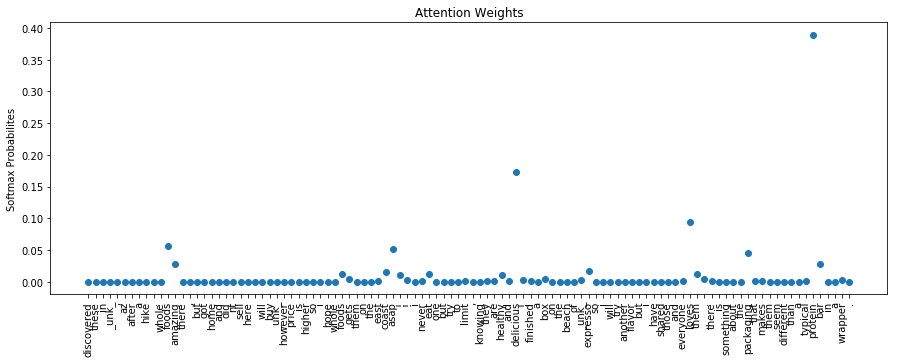

*********************************************************************************************************************


ORIGINAL TEXT:
as advertised this drink gives you a long boost when you need energy and you are out of it . with a very fruity flavor the drink delivers its promises .
ORIGINAL SUMMARY:
_bos_ a long boost _eos_
MODEL PREDICTION:
_bos_ delicious _eos_ drink


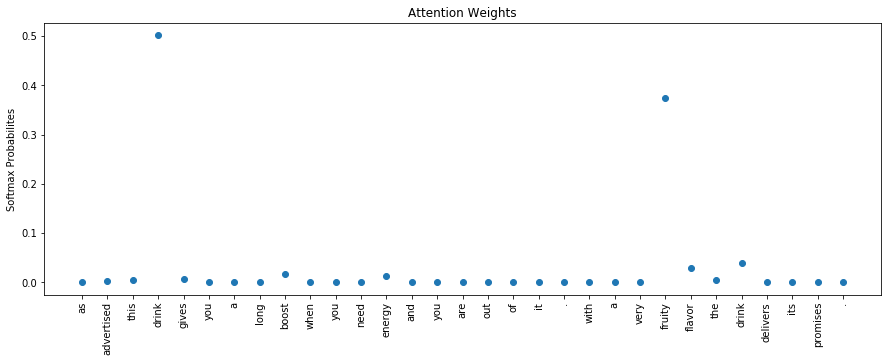

*********************************************************************************************************************


ORIGINAL TEXT:
we first tasted ginseng coffee on a vacation in italy last year . unable to find it in stores where we live , it finally _unk_ on me to check on amazon . gold choice looked like a good choice , so i ordered three lbs as a christmas gift for my husband . it arrived on time , and this instant coffee product tastes exactly as we remembered . full bodied , rich flavor and aroma make it an absolutely delicious special treat . good mail order service . we 'll be ordering here again very soon . highly recommended .
ORIGINAL SUMMARY:
_bos_ dessert in a cup _eos_
MODEL PREDICTION:
_bos_ good _eos_ _eos_


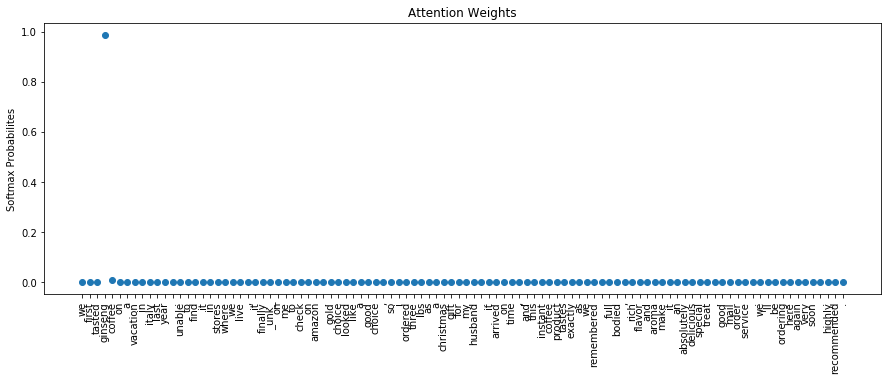

*********************************************************************************************************************


ORIGINAL TEXT:
i love this tea and i hate that it is so hard to find ! i am so glad it is available on amazon !
ORIGINAL SUMMARY:
_bos_ this tea should n't be so hard to find ! _eos_
MODEL PREDICTION:
_bos_ amazing _eos_ !


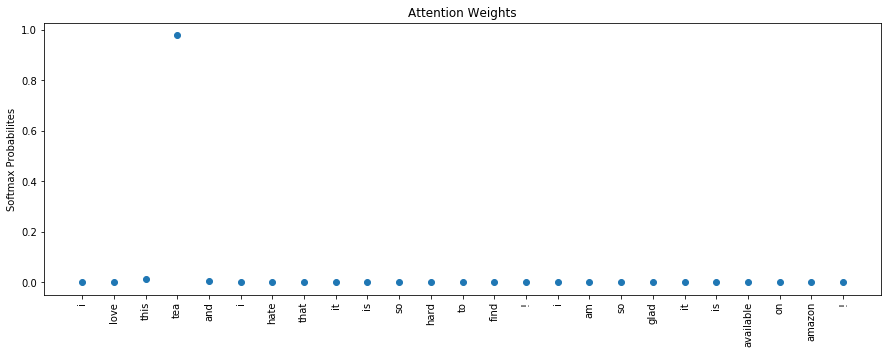

*********************************************************************************************************************


ORIGINAL TEXT:
as a curry fan , i like the savory aroma delivered by the finished product . unless your taste buds are really sensitive , do n't be fooled by the " hot " _unk_ ; this is at best somewhat spicy , and downright mild compared to restaurant curry . but when prepared and served as directed , it makes for a satisfying cool - weather meal ; i recommend using diced chicken meat , carrots , onions , and green peppers .
ORIGINAL SUMMARY:
_bos_ house vermont curry _eos_
MODEL PREDICTION:
_bos_ mandarin ! _eos_


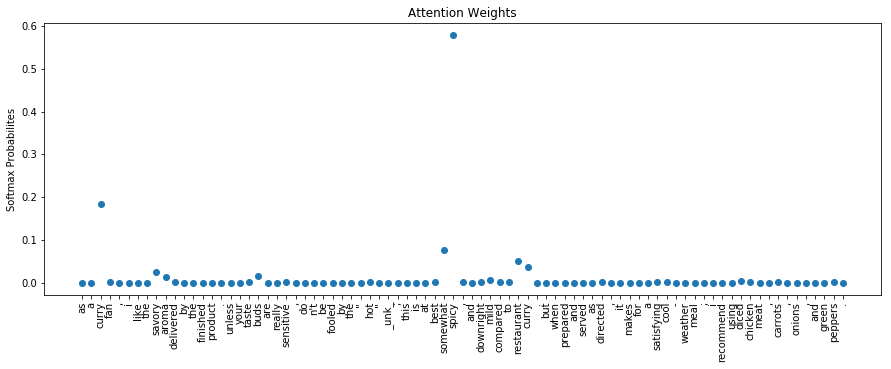

*********************************************************************************************************************


ORIGINAL TEXT:
i buy these for my son . like me he loves his chocolates and this is one of his favorites but not mine . these are always very fresh and packaged well . i did not buy this particular one here , but i got the same item in a local warehouse store near me . i find that these are a very good bar for the adults in the house , but be careful the little ones will like these also . yummy ......
ORIGINAL SUMMARY:
_bos_ for my son , he loves them _eos_
MODEL PREDICTION:
_bos_ yummy and _eos_


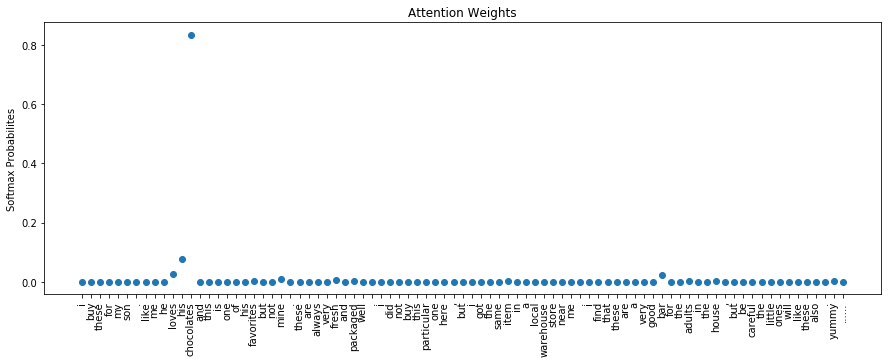

*********************************************************************************************************************


0
ORIGINAL TEXT:
i really like dreamfields pasta . my husband is a diabetic . he can eat dreamfields pasta without having his blood sugars affected . i ordered a case of lasagna noodles because i could not find them at our local grocery < a href="http://www.amazon.com / gp / product / _unk_ > dreamfields pasta healthy carb living , lasagna , _unk_ boxes ( pack of 12)</a > stores . when they arrived one box was broken and the lasagna in several boxes was quite broken up . i will have to make the best of it , fortunately they are now selling dreamfields lasagna noodles at our local " top 's " .
ORIGINAL SUMMARY:
_bos_ arrived in poor condition _eos_
MODEL PREDICTION:
_bos_ the . _eos_


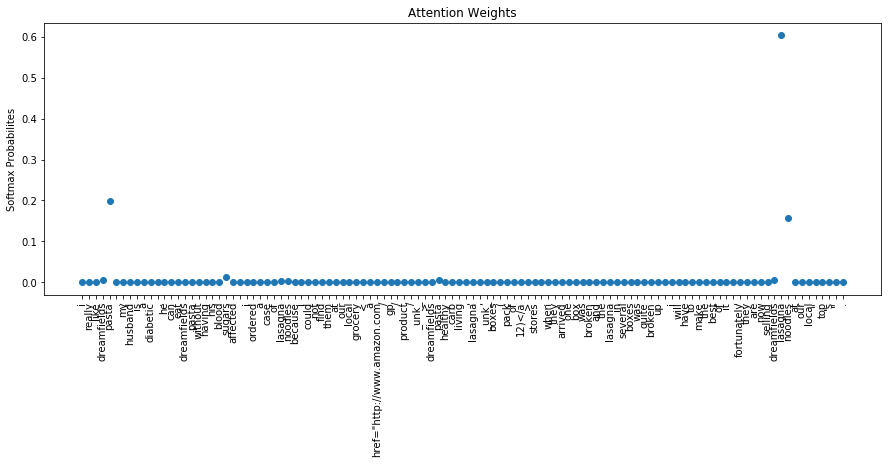

*********************************************************************************************************************


0
ORIGINAL TEXT:
go on , so i let my guard down and decided to take a breath while the noodles and i were in the same room . silly me , i thought to myself . i 've been fooled by the _unk_ of amazon reviewers . sure they do have a smell , but steaming up some brussels sprout will leave you worse off . a _unk_ generous rinse of hot water in my favorite yellow tupperware strainer _unk_ a healthy portion of stench - free noodles . then i decided to do what no man has _unk_ to do before ! i reach into the strainer with my index finger and _unk_ thumb , _unk_ a tablespoon - sized serving of plain hot rinsed noodles , and stuck them directly in my mouth ! _unk_ .... nothing happened . so i made my spaghetti and had a great day .
ORIGINAL SUMMARY:
_bos_ the shirataki experiment _eos_
MODEL PREDICTION:
_bos_ great _eos_ _eos_


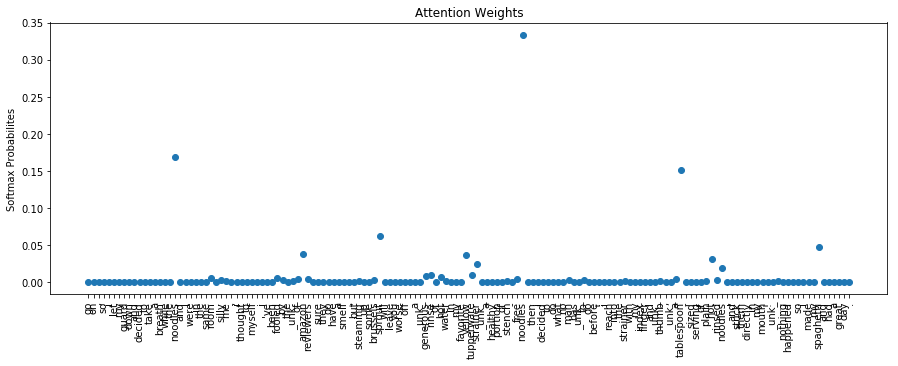

*********************************************************************************************************************


ORIGINAL TEXT:
i 'm not a particularly finicky eater but these oats contain too many husks . i 've tried several other brands plus other country choice oat cereals and have never encountered so many husks , the hard inedible oat cover . after every breakfast there is a stack of at least a half dozen husks on my place mat . these oats taste fine but the husks might be a deal breaker for me .
ORIGINAL SUMMARY:
_bos_ oats and husks _eos_
MODEL PREDICTION:
_bos_ a good ! _eos_


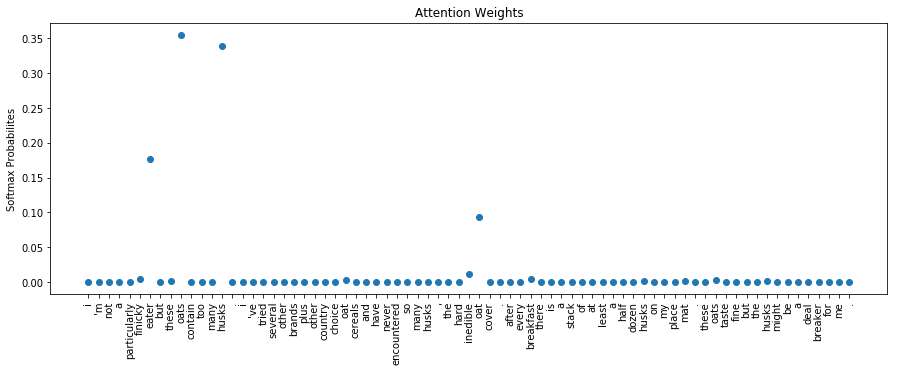

*********************************************************************************************************************


ORIGINAL TEXT:
my husband was addicted to the _unk_ olive mix , but since this was priced so much better we gave it a try . although i would give it one less star , this mix is very tasty and is a good value . we enjoyed the seasoning .
ORIGINAL SUMMARY:
_bos_ quite tasty _eos_
MODEL PREDICTION:
_bos_ great , _eos_


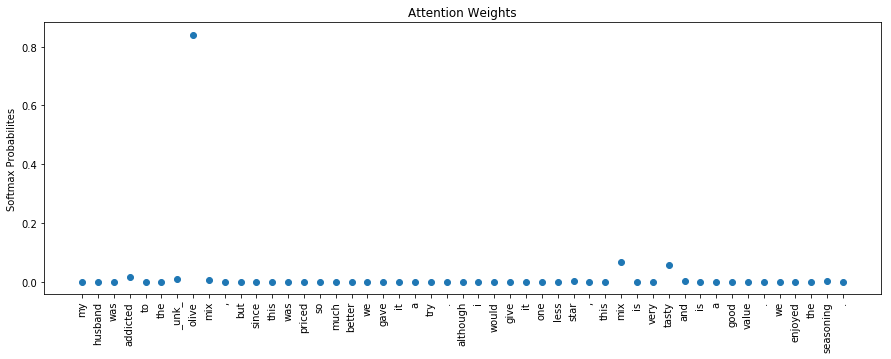

*********************************************************************************************************************




In [76]:
for idx in range(100, 110):
    generate_example(text=test_text, summary=test_summary, idx=idx, plot_attention=True, 
                     pad=all_text_model.word2idx['_pad_'], unk=all_text_model.word2idx['_unk_'])

# Future Improvements
- Test different hyper-parameters for the model. Will more GRU layers help? How about different activation functions in the attention mechanism.
- Reorder the training text so that each batch of text has a similar number of `pad` tokens. Should help the model train a bit faster
- Train the embedding layers
- Different attention mechanisms